# Imports

In [1]:
# Standard libs
import math
import logging
import re
import json
import itertools
from io import StringIO
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import progressbar
from importlib import reload  

# Science libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# ML specific
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Import util functions
import utils

# Extras
import string
import requests
import datetime
import progressbar
import time
import lxml

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


# Change 
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Setup viz
%matplotlib inline

TM_pal_primary = ['#ef4631', '#020202', '#3c3a3b', '#b4b4b4']

TM_pal_sequential_terr = ['#fff8ef', '#ffcc99', '#fb8a5f', '#e75031', '#c30202']
TM_pal_sequential_tund = ['#f0f0f0', '#bfbebe', '#918f90', '#656363', '#3c3a3b']

TM_pal_divergent_tc = ['#10b9ce', '#a6d9de', '#fff8ef', '#ffa68e', '#ef4631']
TM_pal_divergent_tt = ['#3c3a3b', '#989390', '#fff8ef', '#ffa68e', '#ef4631']

TM_pal_categorical_3 = ['#ef4631', '#10b9ce', '#ff9138']
TM_pal_categorical_5 = ['#ef4631', '#10b9ce', '#72dde9', '#ff9138', '#ffb478']
TM_pal_categorical_10 = ['#ef4631', '#f47f71', '#10b9ce', '#72dde9', '#2292ec',
                         '#66b4f2', '#ff9138', '#ffb478', '#3f50b0', '#7a86c8']

sns.set(style='white',
        palette=TM_pal_categorical_3,
        rc={'axes.edgecolor': TM_pal_primary[3],
            'axes.spines.top': False,
            'axes.spines.right': False,
            'font.family': ['sans-serif'],
            'font.sans-serif': ['Helvetica Neue'],
            'font.weight': 'light', # Can be medium or light
            'grid.alpha': 0.5,
            'grid.color': TM_pal_primary[3],
            'text.color': TM_pal_primary[1],
            'xtick.color': TM_pal_primary[1],
            'xtick.labelsize': 13,
            'ytick.color': TM_pal_primary[1],
            'ytick.labelsize': 13})

# Data

In [3]:
# Read
df_raw = pd.read_csv('../data/df_lags_2018.csv')
df_raw.head()

index  season    month year_month_day             datetime  \
0      0    2018  october     2018-10-16  2018-10-16 20:00:00   
1      1    2018  october     2018-10-16  2018-10-16 22:30:00   
2      2    2018  october     2018-10-17  2018-10-17 19:00:00   
3      3    2018  october     2018-10-17  2018-10-17 22:30:00   
4      4    2018  october     2018-10-17  2018-10-17 19:00:00   

               home_team              away_team  home_pts  away_pts  \
0         Boston Celtics     Philadelphia 76ers       105        87   
1  Golden State Warriors  Oklahoma City Thunder       108       100   
2          Orlando Magic             Miami Heat       104       101   
3           Phoenix Suns       Dallas Mavericks       121       100   
4        Detroit Pistons          Brooklyn Nets       103       100   

                                        url_boxscore  home_result  \
0  https://www.basketball-reference.com//boxscore...          1.0   
1  https://www.basketball-reference.com//boxscore...          1.0   
2  https://www.basketball-reference.com//boxscore...          1.0   
3  https://www.basketball-reference.com//boxscore...          1.0   
4  https://www.basketball-reference.com//boxscore...          1.0   

   away_result  home_pts_differential  away_pts_differential  total_pts  \
0          0.0                     18                    -18        192   
1          0.0                      8                     -8        208   
2          0.0                      3                     -3        205   
3          0.0                     21                    -21        221   
4          0.0                      3                     -3        203   

   home_win_cumsum  home_game_number  home_win_percentage_cumsum  \
0                1                 1                         1.0   
1                1                 1                         1.0   
2                1                 1                         1.0   
3                1                 1                         1.0   
4                1                 1                         1.0   

   away_win_cumsum  away_game_number  away_win_percentage_cumsum  \
0                0                 1                         0.0   
1                0                 1                         0.0   
2                0                 1                         0.0   
3                0                 1                         0.0   
4                0                 1                         0.0   

   scored_1_home  allowed_1_home  result_1_home  pts_differential_1_home  \
0            NaN             NaN            NaN                      NaN   
1            NaN             NaN            NaN                      NaN   
2            NaN             NaN            NaN                      NaN   
3            NaN             NaN            NaN                      NaN   
4            NaN             NaN            NaN                      NaN   

   game_number_1_home  win_cumsum_1_home  win_percentage_cumsum_1_home  \
0                 NaN                NaN                           NaN   
1                 NaN                NaN                           NaN   
2                 NaN                NaN                           NaN   
3                 NaN                NaN                           NaN   
4                 NaN                NaN                           NaN   

   time_delta_1_home  time_delta_cumsum_1_home  timezone_diff_1_home  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   timezone_diff_cumsum_1_home  scored_2_home  allowed_2_home  result_2_home  \
0                          NaN            NaN             NaN            NaN   
1     

# Treatment of NULLs

In [4]:
all_features = [
            
        # Non-dynamic features (projected season win rate) 
        'home_projected_winloss',
        'away_projected_winloss',
            
        # Non-lagged dynamic features     
        'home_kde_lag20_prob',
        'game_number_1_home',
        'win_cumsum_1_home',
        'win_percentage_cumsum_1_home',
        'game_number_1_away',
        'win_cumsum_1_away',
        'win_percentage_cumsum_1_away',
        'game_number_1_home_home',
        'win_cumsum_1_home_home',
        'win_percentage_cumsum_1_home_home',
        'game_number_1_away_away',
        'win_cumsum_1_away_away',
        'win_percentage_cumsum_1_away_away',


        # Lagged features (raw)
        'scored_1_home',
        'allowed_1_home',
        'result_1_home',
        'pts_differential_1_home',
        'time_delta_1_home',
        'time_delta_cumsum_1_home',
        'timezone_diff_1_home',
        'timezone_diff_cumsum_1_home',
        'scored_2_home',
        'allowed_2_home',
        'result_2_home',
        'pts_differential_2_home',
        'game_number_2_home',
        'win_cumsum_2_home',
        'win_percentage_cumsum_2_home',
        'time_delta_2_home',
        'time_delta_cumsum_2_home',
        'timezone_diff_2_home',
        'timezone_diff_cumsum_2_home',
        'scored_3_home',
        'allowed_3_home',
        'result_3_home',
        'pts_differential_3_home',
        'game_number_3_home',
        'win_cumsum_3_home',
        'win_percentage_cumsum_3_home',
        'time_delta_3_home',
        'time_delta_cumsum_3_home',
        'timezone_diff_3_home',
        'timezone_diff_cumsum_3_home',
        'scored_4_home',
        'allowed_4_home',
        'result_4_home',
        'pts_differential_4_home',
        'game_number_4_home',
        'win_cumsum_4_home',
        'win_percentage_cumsum_4_home',
        'time_delta_4_home',
        'time_delta_cumsum_4_home',
        'timezone_diff_4_home',
        'timezone_diff_cumsum_4_home',
        'scored_1_away',
        'allowed_1_away',
        'result_1_away',
        'pts_differential_1_away',
        'time_delta_1_away',
        'time_delta_cumsum_1_away',
        'timezone_diff_1_away',
        'timezone_diff_cumsum_1_away',
        'scored_2_away',
        'allowed_2_away',
        'result_2_away',
        'pts_differential_2_away',
        'game_number_2_away',
        'win_cumsum_2_away',
        'win_percentage_cumsum_2_away',
        'time_delta_2_away',
        'time_delta_cumsum_2_away',
        'timezone_diff_2_away',
        'timezone_diff_cumsum_2_away',
        'scored_3_away',
        'allowed_3_away',
        'result_3_away',
        'pts_differential_3_away',
        'game_number_3_away',
        'win_cumsum_3_away',
        'win_percentage_cumsum_3_away',
        'time_delta_3_away',
        'time_delta_cumsum_3_away',
        'timezone_diff_3_away',
        'timezone_diff_cumsum_3_away',
        'scored_4_away',
        'allowed_4_away',
        'result_4_away',
        'pts_differential_4_away',
        'game_number_4_away',
        'win_cumsum_4_away',
        'win_percentage_cumsum_4_away',
        'time_delta_4_away',
        'time_delta_cumsum_4_away',
        'timezone_diff_4_away',
        'timezone_diff_cumsum_4_away',
        'scored_1_home_home',
        'allowed_1_home_home',
        'result_1_home_home',
        'pts_differential_1_home_home',
        'scored_2_home_home',
        'allowed_2_home_home',
        'result_2_home_home',
        'pts_differential_2_home_home',
        'game_number_2_home_home',
        'win_cumsum_2_home_home',
        'win_percentage_cumsum_2_home_home',
        'scored_3_home_home',
        'allowed_3_home_home',
        'result_3_home_home',
        'pts_differential_3_home_home',
        'game_number_3_home_home',
        'win_cumsum_3_home_home',
        'win_percentage_cumsum_3_home_home',
        'scored_4_home_home',
        'allowed_4_home_home',
        'result_4_home_home',
        'pts_differential_4_home_home',
        'game_number_4_home_home',
        'win_cumsum_4_home_home',
        'win_percentage_cumsum_4_home_home',
        'scored_1_away_away',
        'allowed_1_away_away',
        'result_1_away_away',
        'pts_differential_1_away_away',
        'scored_2_away_away',
        'allowed_2_away_away',
        'result_2_away_away',
        'pts_differential_2_away_away',
        'game_number_2_away_away',
        'win_cumsum_2_away_away',
        'win_percentage_cumsum_2_away_away',
        'scored_3_away_away',
        'allowed_3_away_away',
        'result_3_away_away',
        'pts_differential_3_away_away',
        'game_number_3_away_away',
        'win_cumsum_3_away_away',
        'win_percentage_cumsum_3_away_away',
        'scored_4_away_away',
        'allowed_4_away_away',
        'result_4_away_away',
        'pts_differential_4_away_away',
        'game_number_4_away_away',
        'win_cumsum_4_away_away',
        'win_percentage_cumsum_4_away_away',

        # Lagged features (aggregated)
        'agg_scored_4_lags_home',
        'agg_allowed_4_lags_home',
        'agg_pts_differential_4_lags_home',
        'agg_total_pts_4_lags_home',
        'agg_win_rate_4_lags_home',
        'agg_time_delta_cumsum_4_lags_home',
        'agg_timezone_diff_cumsum_4_lags_home',
        'agg_scored_4_lags_away',
        'agg_allowed_4_lags_away',
        'agg_pts_differential_4_lags_away',
        'agg_total_pts_4_lags_away',
        'agg_win_rate_4_lags_away',
        'agg_time_delta_cumsum_4_lags_away',
        'agg_timezone_diff_cumsum_4_lags_away',
        'agg_scored_4_lags_home_home',
        'agg_allowed_4_lags_home_home',
        'agg_pts_differential_4_lags_home_home',
        'agg_total_pts_4_lags_home_home',
        'agg_win_rate_4_lags_home_home',
        'agg_scored_4_lags_away_away',
        'agg_allowed_4_lags_away_away',
        'agg_pts_differential_4_lags_away_away',
        'agg_total_pts_4_lags_away_away',
        'agg_win_rate_4_lags_away_away',
        'agg_time_delta_cumsum_4_lags_away_away',
        'agg_timezone_diff_cumsum_4_lags_away_away',
        ]

In [5]:
# Drop na's for feature columns
print(len(df_raw))
df_raw = df_raw.dropna(subset=all_features)
print(len(df_raw))

1230
1065


# Split

In [6]:
# Example: 
# Set cutoff dates
cutoff_date_train = '2018-11-15'
cutoff_date_test = '2019-01-01'
cutoff_date_valid = '2019-02-20'

# Get train, test, validation sets
train, test, valid = utils.time_splitter(df_raw, cutoff_date_train, cutoff_date_test, cutoff_date_valid)

# Transformations

In [7]:
# Make index list for easy searching later
index_list = [
    'index', 'season', 'month', 'year_month_day', 'datetime', 'home_team', 'away_team', 'home_pts', 'away_pts', 'url_boxscore', 'result'
]

In [8]:
# Example:
# Transform df
train_transformed, train_scaler = utils.feature_transformer(train, all_features, index_list)
test_transformed, train_scaler = utils.feature_transformer(test, all_features, index_list, train_scaler)
valid_transformed, train_scaler = utils.feature_transformer(valid, all_features, index_list, train_scaler)

In [9]:
reload(utils)

<module 'utils' from 'C:\\Users\\Kevin Go\\Desktop\\projects\\nba_prediction_learning\\experiments\\utils.py'>

In [10]:
# Split X's and y's
X_train, y_train = utils.X_y_splitter(train_transformed, all_features, 'result')
X_test, y_test = utils.X_y_splitter(test_transformed, all_features, 'result')
X_valid, y_valid = utils.X_y_splitter(valid_transformed, all_features, 'result')

# Feature selection using ANOVA

In [11]:
def feature_selector(feature_set):
    """
    Return list of features, given a feature set name.
    
    Inputs:
    feature_set: (string) Name of feature set.
    
    """
    
    # Feature Set 01 - All features
    if feature_set == 'feature_set_01':
        features = all_features
        
        
    # Feature Set 02 - Long term dynamic features + short term dynamic (aggregated)
    if feature_set == 'feature_set_02':
        
        features = [
        # Long term dynamic features
        'home_kde_lag20_prob',
        'game_number_1_home',
        'win_cumsum_1_home',
        'win_percentage_cumsum_1_home',
        'game_number_1_away',
        'win_percentage_cumsum_1_away',
        'win_cumsum_1_away',

        # Short term dynamic (aggregated)
        'agg_scored_4_lags_home',
        'agg_allowed_4_lags_home',
        'agg_pts_differential_4_lags_home',
        'agg_total_pts_4_lags_home',
        'agg_win_rate_4_lags_home',
        'agg_time_delta_cumsum_4_lags_home',
        'agg_timezone_diff_cumsum_4_lags_home',
        'agg_scored_4_lags_away',
        'agg_allowed_4_lags_away',
        'agg_pts_differential_4_lags_away',
        'agg_total_pts_4_lags_away',
        'agg_win_rate_4_lags_away',
        'agg_time_delta_cumsum_4_lags_away',
        'agg_timezone_diff_cumsum_4_lags_away'
        ]
        
    # Feature Set 03 - Long term dynamic features + short term dynamic (aggregated) + side-specific features
    if feature_set == "feature_set_03":
        
        features = [
        # Long term dynamic features
        'home_kde_lag20_prob',
        'game_number_1_home',
        'win_cumsum_1_home',
        'win_percentage_cumsum_1_home',
        'game_number_1_away',
        'win_cumsum_1_away',
        'win_percentage_cumsum_1_away',
        'game_number_1_home_home',
        'win_cumsum_1_home_home',
        'win_percentage_cumsum_1_home_home',
        'game_number_1_away_away',
        'win_cumsum_1_away_away',
        'win_percentage_cumsum_1_away_away',
            
        # Short term dynamic (aggregated)
        'agg_scored_4_lags_home',
        'agg_allowed_4_lags_home',
        'agg_pts_differential_4_lags_home',
        'agg_total_pts_4_lags_home',
        'agg_win_rate_4_lags_home',
        'agg_time_delta_cumsum_4_lags_home',
        'agg_timezone_diff_cumsum_4_lags_home',
        'agg_scored_4_lags_away',
        'agg_allowed_4_lags_away',
        'agg_pts_differential_4_lags_away',
        'agg_total_pts_4_lags_away',
        'agg_win_rate_4_lags_away',
        'agg_time_delta_cumsum_4_lags_away',
        'agg_timezone_diff_cumsum_4_lags_away',
        'agg_scored_4_lags_home_home',
        'agg_allowed_4_lags_home_home',
        'agg_pts_differential_4_lags_home_home',
        'agg_total_pts_4_lags_home_home',
        'agg_win_rate_4_lags_home_home',
        'agg_scored_4_lags_away_away',
        'agg_allowed_4_lags_away_away',
        'agg_pts_differential_4_lags_away_away',
        'agg_total_pts_4_lags_away_away',
        'agg_win_rate_4_lags_away_away',
        'agg_time_delta_cumsum_4_lags_away_away',
        'agg_timezone_diff_cumsum_4_lags_away_away',
        ]
        
    # Feature Set 04 - Long term dynamic features + short term dynamic (aggregated) + side-specific features + projected season record
    if feature_set == 'feature_set_04':
        features = [    
        # Non-dynamic features (projected season record) 
        'home_projected_winloss',
        'away_projected_winloss',
            
        # Long term dynamic features
        'home_kde_lag20_prob',
        'game_number_1_home',
        'win_cumsum_1_home',
        'win_percentage_cumsum_1_home',
        'game_number_1_away',
        'win_cumsum_1_away',
        'win_percentage_cumsum_1_away',
        'game_number_1_home_home',
        'win_cumsum_1_home_home',
        'win_percentage_cumsum_1_home_home',
        'game_number_1_away_away',
        'win_cumsum_1_away_away',
        'win_percentage_cumsum_1_away_away',
            
        # Short term dynamic (aggregated)
        'agg_scored_4_lags_home',
        'agg_allowed_4_lags_home',
        'agg_pts_differential_4_lags_home',
        'agg_total_pts_4_lags_home',
        'agg_win_rate_4_lags_home',
        'agg_time_delta_cumsum_4_lags_home',
        'agg_timezone_diff_cumsum_4_lags_home',
        'agg_scored_4_lags_away',
        'agg_allowed_4_lags_away',
        'agg_pts_differential_4_lags_away',
        'agg_total_pts_4_lags_away',
        'agg_win_rate_4_lags_away',
        'agg_time_delta_cumsum_4_lags_away',
        'agg_timezone_diff_cumsum_4_lags_away',
        'agg_scored_4_lags_home_home',
        'agg_allowed_4_lags_home_home',
        'agg_pts_differential_4_lags_home_home',
        'agg_total_pts_4_lags_home_home',
        'agg_win_rate_4_lags_home_home',
        'agg_scored_4_lags_away_away',
        'agg_allowed_4_lags_away_away',
        'agg_pts_differential_4_lags_away_away',
        'agg_total_pts_4_lags_away_away',
        'agg_win_rate_4_lags_away_away',
        'agg_time_delta_cumsum_4_lags_away_away',
        'agg_timezone_diff_cumsum_4_lags_away_away',
        ]
        
    # Top n features
    if feature_set == 'feature_set_05':
        features = top_10_features_all
        
    # Top n features
    if feature_set == 'feature_set_06':
        features = top_10_features_set_02
        
    return(features)

In [12]:
top_10_features_all = utils.top_features(train_transformed, all_features, 10, 'result')
top_10_features_all

['win_percentage_cumsum_3_home',
 'win_percentage_cumsum_1_home',
 'home_projected_winloss',
 'win_percentage_cumsum_1_home_home',
 'win_percentage_cumsum_4_home',
 'win_percentage_cumsum_2_home',
 'win_percentage_cumsum_4_home_home',
 'win_percentage_cumsum_3_home_home',
 'home_kde_lag20_prob',
 'win_percentage_cumsum_2_home_home']

In [13]:
top_10_features_set_02 = utils.top_features(train_transformed, feature_selector("feature_set_02"), 10, 'result')
top_10_features_set_02

['win_percentage_cumsum_1_home',
 'home_kde_lag20_prob',
 'agg_pts_differential_4_lags_home',
 'win_cumsum_1_home',
 'agg_scored_4_lags_home',
 'win_percentage_cumsum_1_away',
 'agg_win_rate_4_lags_home',
 'agg_allowed_4_lags_home',
 'agg_time_delta_cumsum_4_lags_home',
 'agg_pts_differential_4_lags_away']

# LR

In [14]:
from sklearn.linear_model import LogisticRegression

## Modeling

In [16]:
random_state_i = 0

In [17]:
# Get first combination of hyperparams
i = 0

# Set params
max_iter_i = 3000
penalty_i = none
feature_set_i = 'feature_set_01'
features_i = feature_selector(feature_set_i)

In [18]:
# Set cutoff dates
cutoff_date_train = '2018-11-01'
cutoff_date_test = '2019-01-01'
cutoff_date_valid = '2019-02-15'

# Make index list for easy searching later
index_list = [
    'index', 'season', 'month', 'year_month_day', 'datetime', 'home_team', 'away_team', 'home_pts', 'away_pts', 'url_boxscore', 'result'
]

# Get train, test, validation sets
train, test, valid = utils.time_splitter(df_raw, cutoff_date_train, cutoff_date_test, cutoff_date_valid)

In [19]:
# Transform df
train_transformed, train_scaler = utils.feature_transformer(train, features_i, index_list)
test_transformed, train_scaler = utils.feature_transformer(test, features_i, index_list, train_scaler)

# Get scaler fitted on train and test
_, train_test_scaler = utils.feature_transformer(train.append(test), features_i, index_list)

# Transform valid using train_test_scaler
valid_transformed, train_scaler = utils.feature_transformer(valid, features_i, index_list, train_test_scaler)

In [20]:
# Split X's and y's
X_train, y_train = utils.X_y_splitter(train_transformed, features_i, 'result')
X_test, y_test = utils.X_y_splitter(test_transformed, features_i, 'result')
X_valid, y_valid = utils.X_y_splitter(valid_transformed, features_i, 'result')

In [21]:
# Train model
estimator = LogisticRegression(max_iter=max_iter_i, penalty=penalty_i, random_state=random_state_i)
estimator.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
reload(utils)

<module 'utils' from 'C:\\Users\\Kevin Go\\Desktop\\projects\\nba_prediction_learning\\experiments\\utils.py'>

In [23]:
# Score: train
predictions_df_train, threseholds_train = utils.scorer(X_train, y_train, estimator, expected_event_rate=0.6)

# Score: test
predictions_df_test, threseholds_test = utils.scorer(X_test, y_test, estimator, expected_event_rate=0.6)

# Score: valid
predictions_df_valid, threseholds_valid = utils.scorer(X_valid, y_valid, estimator, expected_event_rate=0.6)
predictions_df_valid = X_valid.reset_index().set_index('index').join(predictions_df_valid)

In [27]:
print(classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold']))

              precision    recall  f1-score   support

         0.0       0.50      0.49      0.49       152
         1.0       0.64      0.66      0.65       212

    accuracy                           0.59       364
   macro avg       0.57      0.57      0.57       364
weighted avg       0.58      0.59      0.58       364



In [28]:
roc_auc_score(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'])

0.5712512413108242

## Set hyperparams

In [15]:
from itertools import product

# Select hyperparams
max_iter = [3000]
penalty = ['none', 'l2']
feature_set = ['feature_set_01', 'feature_set_02', 'feature_set_03', 'feature_set_04', 'feature_set_05', 'feature_set_06']

# Combinations of hyperparams
params_df = pd.DataFrame(product(max_iter, penalty, feature_set))
params_df.columns = ['max_iter', 'penalty', 'feature_set']
params_df

max_iter penalty     feature_set
0       3000    none  feature_set_01
1       3000    none  feature_set_02
2       3000    none  feature_set_03
3       3000    none  feature_set_04
4       3000    none  feature_set_05
5       3000    none  feature_set_06
6       3000      l2  feature_set_01
7       3000      l2  feature_set_02
8       3000      l2  feature_set_03
9       3000      l2  feature_set_04
10      3000      l2  feature_set_05
11      3000      l2  feature_set_06

In [29]:
# Train and score over hyperparameter combinations
experiments = {}

import progressbar
length = params_df
bar = progressbar.ProgressBar(maxval=len(length))
bar.start()

for i in range(len(length)):
    
    # Start recording time
    t0 = time.time()
    
    # Set params
    max_iter_i = params_df.loc[i,'max_iter']
    penalty_i = params_df.loc[i,'penalty']
    feature_set_i = params_df.loc[i,'feature_set']
    features_i = feature_selector(feature_set_i)
    
    # Set cutoff dates
    cutoff_date_train = '2018-11-01'
    cutoff_date_test = '2019-01-01'
    cutoff_date_valid = '2019-02-15'

    # Make index list for easy searching later
    index_list = [
        'index', 'season', 'month', 'year_month_day', 'datetime', 'home_team', 'away_team', 'home_pts', 'away_pts', 'url_boxscore', 'result'
    ]

    # Get train, test, validation sets
    train, test, valid = utils.time_splitter(df_raw, cutoff_date_train, cutoff_date_test, cutoff_date_valid)
    
    # Transform df
    train_transformed, train_scaler = utils.feature_transformer(train, features_i, index_list)
    test_transformed, train_scaler = utils.feature_transformer(test, features_i, index_list, train_scaler)
    
    # Get scaler fitted on train and test
    _, train_test_scaler = utils.feature_transformer(train.append(test), features_i, index_list)
    
    # Transform valid using train_test_scaler
    valid_transformed, train_scaler = utils.feature_transformer(valid, features_i, index_list, train_test_scaler)

    # Split X's and y's
    X_train, y_train = utils.X_y_splitter(train_transformed, features_i, 'result')
    X_test, y_test = utils.X_y_splitter(test_transformed, features_i, 'result')
    X_valid, y_valid = utils.X_y_splitter(valid_transformed, features_i, 'result')

    # Train model
    estimator = LogisticRegression(max_iter=max_iter_i, penalty=penalty_i, random_state=random_state_i)
    estimator.fit(X_train, y_train)
    
    # Score: train
    predictions_df_train, threshold_finder_train = utils.scorer(X_train, y_train, estimator, expected_event_rate=0.6)

    # Score: test
    predictions_df_test, threshold_finder_test = utils.scorer(X_test, y_test, estimator, expected_event_rate=0.6)
    
    # Score: valid
    predictions_df_valid, threshold_finder_valid = utils.scorer(X_valid, y_valid, estimator, expected_event_rate=0.6)
    predictions_df_valid = X_valid.reset_index().set_index('index').join(predictions_df_valid)
    
    # Compile results 
    results = {
        'train precision': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'train recall': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'train f1': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'train roc': roc_auc_score(predictions_df_train['actual'], predictions_df_train['pred_best_threshold']),
        'test precision': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'test recall': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'test f1': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'test roc': roc_auc_score(predictions_df_test['actual'], predictions_df_test['pred_best_threshold']),
        'valid precision': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'valid recall': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'valid f1': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'valid roc': roc_auc_score(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'])
    }
    
    # Compile experiment params
    params = {
        'max_iter': max_iter_i,
        'penalty': penalty_i,
        'feature_set': feature_set_i,
        'train size': len(X_train),
        'test size': len(X_test),
        'valid size': len(X_valid),
        'runtime': time.time() - t0
    }
    
    # Compile all
    experiments[i] = {
        'params': params,
        'results': results,
        'estimator': estimator,
        'predictions_df_valid': predictions_df_valid,
        'X_valid': X_valid,
    }
    
    bar.update(i)

 91% (11 of 12) |######################  | Elapsed Time: 0:00:02 ETA:   0:00:00

In [30]:
# Compile experiment results
experiments_df = pd.DataFrame()
for i in experiments.keys():
    experiments_df = experiments_df.append(pd.DataFrame({**experiments[i]['params'], **experiments[i]['results']}, index=[i]))
experiments_df.sort_values('valid precision', ascending=False).head()

max_iter penalty     feature_set  train size  test size  valid size  \
7       3000      l2  feature_set_02         383        318         364   
11      3000      l2  feature_set_06         383        318         364   
5       3000    none  feature_set_06         383        318         364   
1       3000    none  feature_set_02         383        318         364   
8       3000      l2  feature_set_03         383        318         364   

     runtime  train precision  train recall  train f1  train roc  \
7   0.160559         0.716157      0.697872  0.706897   0.629342   
11  0.149599         0.707424      0.689362  0.698276   0.618329   
5   0.186502         0.701754      0.680851  0.691145   0.610696   
1   0.196475         0.716738      0.710638  0.713675   0.632346   
8   0.188003         0.728070      0.706383  0.717063   0.643732   

    test precision  test recall   test f1  test roc  valid precision  \
7         0.721053     0.752747  0.736559  0.681521         0.700000   
11        0.723958     0.763736  0.743316  0.687015         0.698630   
5         0.727749     0.763736  0.745308  0.690692         0.695455   
1         0.705263     0.736264  0.720430  0.662250         0.694444   
8         0.705882     0.725275  0.715447  0.660431         0.675926   

    valid recall  valid f1  valid roc  
7       0.726415  0.712963   0.646102  
11      0.721698  0.709977   0.643744  
5       0.721698  0.708333   0.640454  
1       0.707547  0.700935   0.636668  
8       0.688679  0.682243   0.614076

## Plot predicted vs actual

In [31]:
# Get results df
target_idx =  7
predictions_df_valid = experiments[target_idx]['predictions_df_valid']

In [32]:
reload(utils)

<module 'utils' from 'C:\\Users\\Kevin Go\\Desktop\\projects\\nba_prediction_learning\\experiments\\utils.py'>

N/A% (0 of 18) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


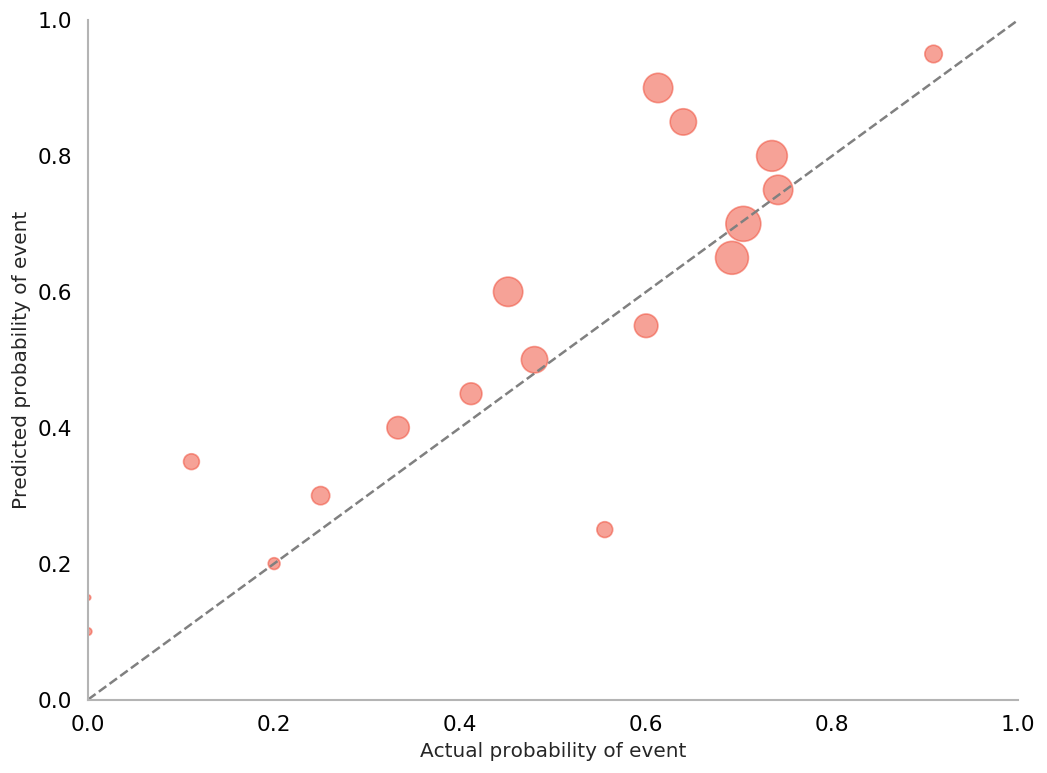

In [33]:
# Plot
for_plotting = utils.plot_probability(target_idx, predictions_df_valid)

In [34]:
abs(for_plotting['predicted_prob'] - for_plotting['actual_prob']).mean()

0.10140905069115064

In [35]:
abs_error = abs(for_plotting['predicted_prob'] - for_plotting['actual_prob'])
proportions = for_plotting['n_games']/sum(for_plotting['n_games'])
sum(abs_error*proportions)

0.08983516483516485

## Plot precision-recall across thresholds

C:\Users\Kevin Go\.conda\envs\nba\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


decision_threshold  precision  recall
0                0.10   0.582418     1.0
1                0.11   0.582418     1.0
2                0.12   0.582418     1.0
3                0.13   0.584022     1.0
4                0.14   0.584022     1.0

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


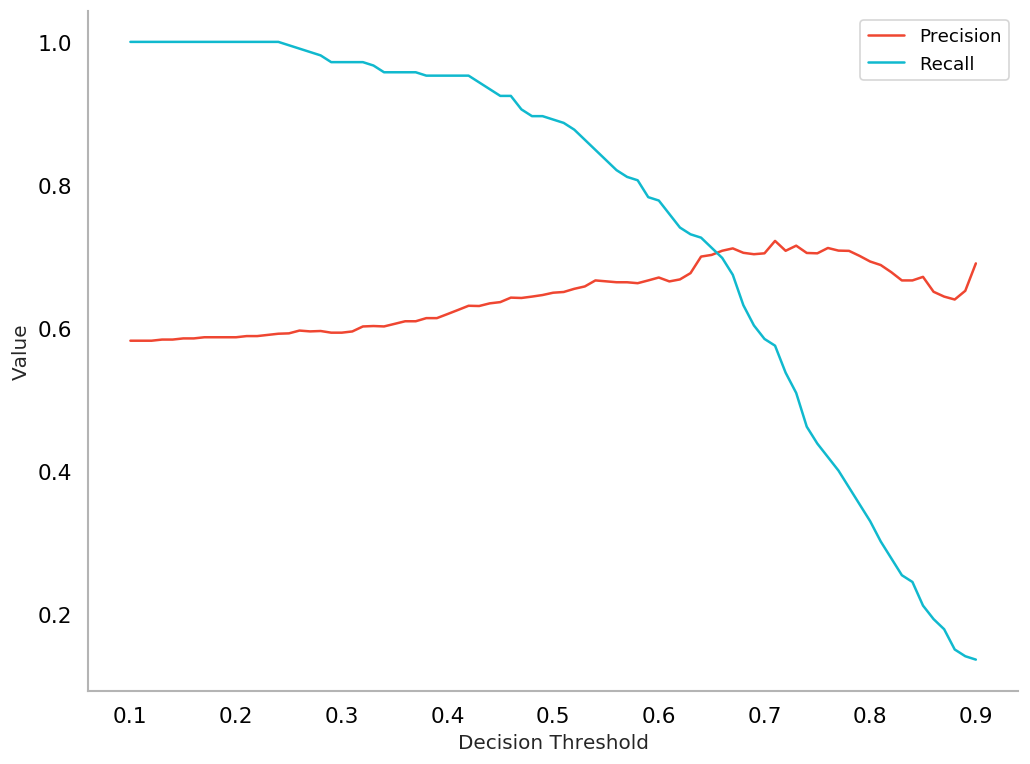

In [36]:
# Plot
y_true = predictions_df_valid['result']
y_pred_proba = predictions_df_valid['pred_proba']
for_plotting = utils.plot_precision_recall(y_true, y_pred_proba)
for_plotting.head()

## Plot ROC curve

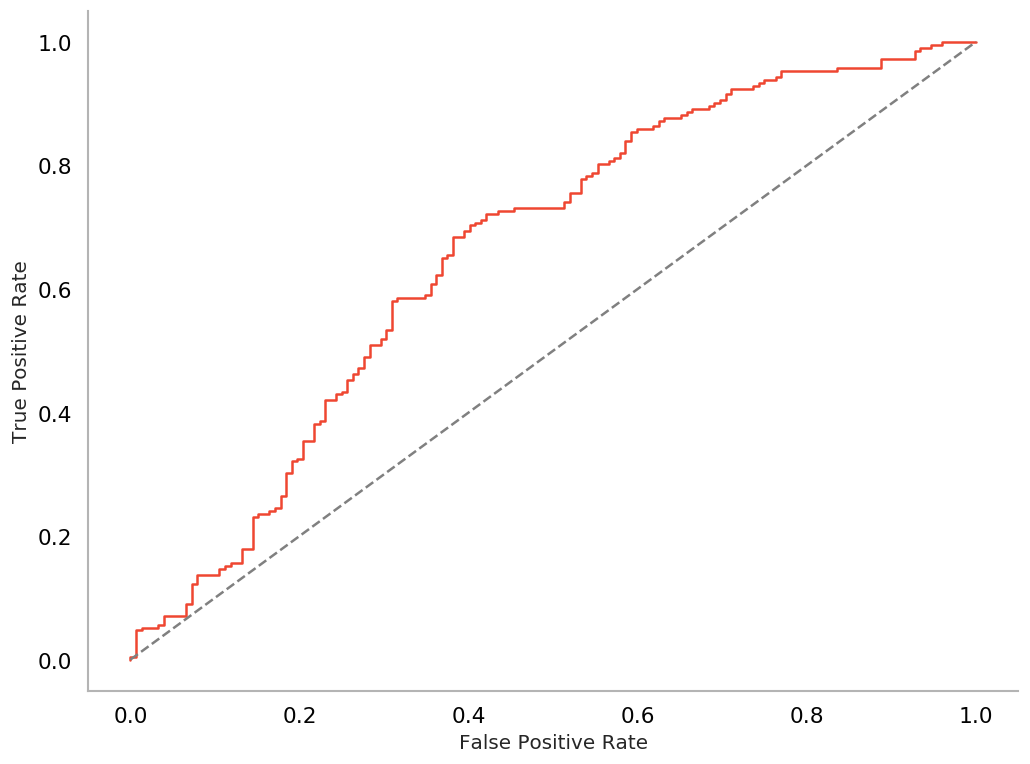

In [37]:
# Plot
y_true = predictions_df_valid['result']
y_pred_proba = predictions_df_valid['pred_proba']
utils.plot_roc_curve(y_true, y_pred_proba)

## Explainability

In [38]:
best_model = experiments[target_idx]['estimator']
best_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
coefs = best_model.coef_
coefs

array([[ 0.06327306, -0.60344717,  0.38482878,  0.12938214,  0.35170764,
        -0.1714303 , -0.01828511,  0.21554541, -0.17049057,  0.32635271,
         0.02730409, -0.47925068,  0.12726434, -0.08744457, -0.01332385,
         0.07390525, -0.07714047,  0.0355597 ,  0.06538709,  0.22013179,
         0.08382494]])

Text(0.5, 0, 'Effect on log-odds')

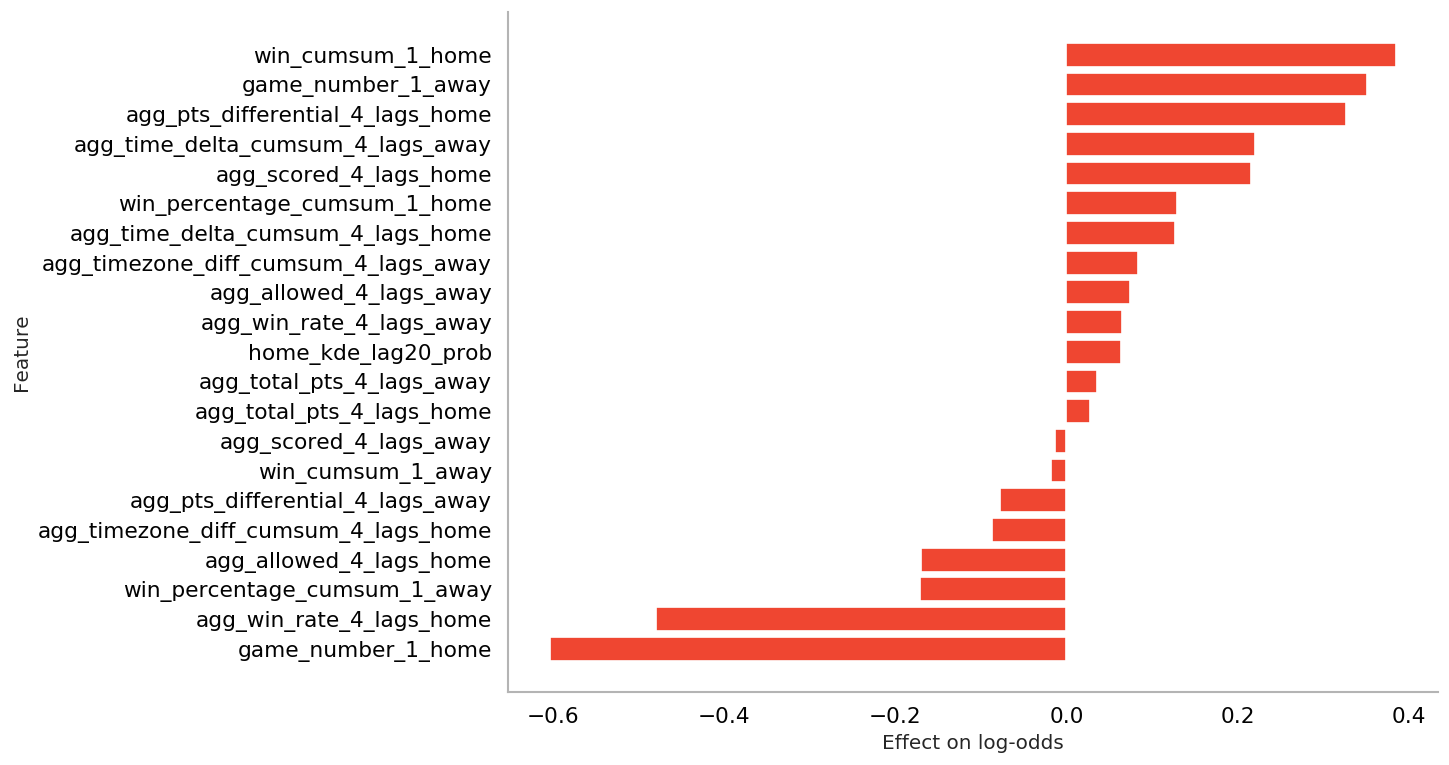

In [40]:
# Plot
for_plotting = pd.DataFrame(
    {
        'feature': experiments[target_idx]['X_valid'].columns.tolist(),
        'value':coefs[0].tolist()
    }
)
for_plotting = for_plotting.sort_values('value',ascending=True)
    
# Plot
fig,ax = plt.subplots()
fig.set_dpi(120)
fig.set_size_inches(10,7.5)
plt.barh(for_plotting['feature'], for_plotting['value'], alpha=1, color=TM_pal_categorical_3[0])
plt.ylabel('Feature')
plt.xlabel('Effect on log-odds')

In [41]:
# Reconstruct probability score of this sample:
sample = predictions_df_valid.head(1)
sample['pred_proba']

index
866    0.431336
Name: pred_proba, dtype: float64

In [42]:
# Get coefs and intercept
coefs = best_model.coef_
intercept = best_model.intercept_

In [43]:
# Get features
feature_set = experiments[target_idx]['params']['feature_set']
features = feature_selector(feature_set)
sample_X = sample[features].values

# Calculate
a = np.exp(sample_X.dot(coefs.transpose()) + intercept)
prob_sample_X = a/(1+a)
prob_sample_X

array([[0.43133592]])

# RF

In [44]:
from sklearn.ensemble import RandomForestClassifier

## Set hyperparams

In [45]:
from itertools import product

# Select hyperparams
n_estimators = [1000]
min_samples_split = [10, 50, 100, 200]

feature_set = ['feature_set_01', 'feature_set_02', 'feature_set_03', 'feature_set_04', 'feature_set_05', 'feature_set_06']

# Combinations of hyperparams
params_df = pd.DataFrame(product(n_estimators, min_samples_split, feature_set))
params_df.columns = ['n_estimators', 'min_samples_split', 'feature_set']
params_df

n_estimators  min_samples_split     feature_set
0           1000                 10  feature_set_01
1           1000                 10  feature_set_02
2           1000                 10  feature_set_03
3           1000                 10  feature_set_04
4           1000                 10  feature_set_05
5           1000                 10  feature_set_06
6           1000                 50  feature_set_01
7           1000                 50  feature_set_02
8           1000                 50  feature_set_03
9           1000                 50  feature_set_04
10          1000                 50  feature_set_05
11          1000                 50  feature_set_06
12          1000                100  feature_set_01
13          1000                100  feature_set_02
14          1000                100  feature_set_03
15          1000                100  feature_set_04
16          1000                100  feature_set_05
17          1000                100  feature_set_06
18          1000                200  feature_set_01
19          1000                200  feature_set_02
20          1000                200  feature_set_03
21          1000                200  feature_set_04
22          1000                200  feature_set_05
23          1000                200  feature_set_06

## Modeling

In [46]:
random_state_i = 0

In [47]:
# Train and score over hyperparameter combinations
experiments = {}

import progressbar
bar = progressbar.ProgressBar(maxval=len(params_df))
bar.start()

for i in range(len(params_df)):
    
    # Start recording time
    t0 = time.time()
    
    # Set params
    n_estimators_i = params_df.loc[i,'n_estimators']
    min_samples_split_i = params_df.loc[i,'min_samples_split']
    feature_set_i = params_df.loc[i,'feature_set']
    features_i = feature_selector(feature_set_i)
    
    # Set cutoff dates
    cutoff_date_train = '2018-11-01'
    cutoff_date_test = '2019-01-01'
    cutoff_date_valid = '2019-02-15'

    # Make index list for easy searching later
    index_list = [
        'index', 'season', 'month', 'year_month_day', 'datetime', 'home_team', 'away_team', 'home_pts', 'away_pts', 'url_boxscore', 'result'
    ]

    # Get train, test, validation sets
    train, test, valid = utils.time_splitter(df_raw, cutoff_date_train, cutoff_date_test, cutoff_date_valid)
    
    # Transform df
    train_transformed, train_scaler = utils.feature_transformer(train, features_i, index_list)
    test_transformed, train_scaler = utils.feature_transformer(test, features_i, index_list, train_scaler)
    
    # Get scaler fitted on train and test
    _, train_test_scaler = utils.feature_transformer(train.append(test), features_i, index_list)
    
    # Transform valid using train_test_scaler
    valid_transformed, train_scaler = utils.feature_transformer(valid, features_i, index_list, train_test_scaler)
    
    # Split X's and y's
    X_train, y_train = utils.X_y_splitter(train_transformed, features_i, 'result')
    X_test, y_test = utils.X_y_splitter(test_transformed, features_i, 'result')
    X_valid, y_valid = utils.X_y_splitter(valid_transformed, features_i, 'result')

    # Train model
    estimator = RandomForestClassifier(n_estimators=n_estimators_i, min_samples_split=min_samples_split_i, random_state=random_state_i)
    estimator.fit(X_train, y_train)
    
    # Score: train
    predictions_df_train, threshold_finder_train = utils.scorer(X_train, y_train, estimator, expected_event_rate=0.6)

    # Score: test
    predictions_df_test, threshold_finder_test = utils.scorer(X_test, y_test, estimator, expected_event_rate=0.6)
    
    # Score: valid
    predictions_df_valid, threshold_finder_valid = utils.scorer(X_valid, y_valid, estimator, expected_event_rate=0.6)
    predictions_df_valid = predictions_df_valid.join(X_valid.reset_index().set_index('index'))
    
    # Compile results 
    results = {
        'train precision': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'train recall': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'train f1': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'train roc': roc_auc_score(predictions_df_train['actual'], predictions_df_train['pred_best_threshold']),
        'test precision': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'test recall': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'test f1': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'test roc': roc_auc_score(predictions_df_test['actual'], predictions_df_test['pred_best_threshold']),
        'valid precision': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'valid recall': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'valid f1': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'valid roc': roc_auc_score(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'])
    }
    
    # Compile experiment params
    params = {
        'n_estimators': n_estimators_i,
        'min_samples_split': min_samples_split_i,
        'feature_set': feature_set_i,
        'train size': len(X_train),
        'test size': len(X_test),
        'valid size': len(X_valid),
        'runtime': time.time() - t0
    }
    
    # Compile all
    experiments[i] = {
        'params': params,
        'results': results,
        'estimator': estimator,
        'predictions_df_valid': predictions_df_valid,
        'X_valid': X_valid
    }
    
    bar.update(i)

 95% (23 of 24) |####################### | Elapsed Time: 0:00:47 ETA:   0:00:01

In [54]:
# Compile experiment results
experiments_df = pd.DataFrame()
for i in experiments.keys():
    experiments_df = experiments_df.append(pd.DataFrame({**experiments[i]['params'], **experiments[i]['results']}, index=[i]))
experiments_df.sort_values('valid precision', ascending=False)
# experiments_df

n_estimators  min_samples_split     feature_set  train size  test size  \
20          1000                200  feature_set_03         383        318   
13          1000                100  feature_set_02         383        318   
19          1000                200  feature_set_02         383        318   
23          1000                200  feature_set_06         383        318   
11          1000                 50  feature_set_06         383        318   
18          1000                200  feature_set_01         383        318   
17          1000                100  feature_set_06         383        318   
14          1000                100  feature_set_03         383        318   
12          1000                100  feature_set_01         383        318   
21          1000                200  feature_set_04         383        318   
15          1000                100  feature_set_04         383        318   
7           1000                 50  feature_set_02         383        318   
4           1000                 10  feature_set_05         383        318   
8           1000                 50  feature_set_03         383        318   
1           1000                 10  feature_set_02         383        318   
9           1000                 50  feature_set_04         383        318   
5           1000                 10  feature_set_06         383        318   
16          1000                100  feature_set_05         383        318   
6           1000                 50  feature_set_01         383        318   
22          1000                200  feature_set_05         383        318   
10          1000                 50  feature_set_05         383        318   
0           1000                 10  feature_set_01         383        318   
3           1000                 10  feature_set_04         383        318   
2           1000                 10  feature_set_03         383        318   

    valid size   runtime  train precision  train recall  train f1  train roc  \
20         364  1.836528         0.737500      0.753191  0.745263   0.663758   
13         364  1.775360         0.801762      0.774468  0.787879   0.735207   
19         364  1.504115         0.764977      0.706383  0.734513   0.680894   
23         364  1.657263         0.725322      0.719149  0.722222   0.643358   
11         364  1.914703         0.839827      0.825532  0.832618   0.787766   
18         364  1.755123         0.776786      0.740426  0.758170   0.701294   
17         364  1.757343         0.777293      0.757447  0.767241   0.706426   
14         364  1.827632         0.801724      0.791489  0.796574   0.740339   
12         364  2.000468         0.843750      0.804255  0.823529   0.783884   
21         364  1.625999         0.746781      0.740426  0.743590   0.670888   
15         364  1.904696         0.788793      0.778723  0.783726   0.723821   
7          364  1.712194         0.850220      0.821277  0.835498   0.795773   
4          364  2.035000         0.978166      0.953191  0.965517   0.959704   
8          364  1.975141         0.884956      0.851064  0.867679   0.837694   
1          364  2.051270         0.995652      0.974468  0.984946   0.983856   
9          364  1.902899         0.864629      0.842553  0.853448   0.816547   
5          364  1.946288         0.991304      0.970213  0.980645   0.978350   
16         364  1.732231         0.754310      0.744681  0.749465   0.679773   
6          364  2.291705         0.925764      0.902128  0.913793   0.893631   
22         364  1.606973         0.726087      0.710638  0.718280   0.642481   
10         364  1.652951         0.828947      0.804255  0.816415   0.770371   
0          364  2.420197         1.000000      0.974468  0.987069   0.987234   
3          364  2.429313         1.000000      0.987234  0.993576   0.993617   
2          364  2.476417         1.000000      0.978723  0.989247   0.989362   

    test precision  test recall   test f1  test roc 

## Plot predicted vs actual

In [59]:
# Get results df
target_idx =  20
predictions_df_valid = experiments[target_idx]['predictions_df_valid'].copy()

# Make new index for shap
predictions_df_valid.reset_index(inplace=True)
predictions_df_valid.rename(columns={'index': 'original_index'}, inplace=True)
predictions_df_valid.head()

original_index  pred_proba  pred_default_threshold  pred_best_threshold  \
0             866    0.589534                     1.0                    0   
1             867    0.629180                     1.0                    1   
2             868    0.687053                     1.0                    1   
3             869    0.524401                     1.0                    0   
4             870    0.636097                     1.0                    1   

   actual  season     month year_month_day             datetime  \
0     1.0    2018  february     2019-02-21  2019-02-21 22:30:00   
1     0.0    2018  february     2019-02-21  2019-02-21 19:30:00   
2     1.0    2018  february     2019-02-21  2019-02-21 22:30:00   
3     1.0    2018  february     2019-02-21  2019-02-21 19:00:00   
4     1.0    2018  february     2019-02-21  2019-02-21 20:00:00   

               home_team               away_team  home_pts  away_pts  \
0     Los Angeles Lakers         Houston Rockets       111       106   
1          Brooklyn Nets  Portland Trail Blazers        99       113   
2  Golden State Warriors        Sacramento Kings       125       123   
3    Cleveland Cavaliers            Phoenix Suns       111        98   
4        Milwaukee Bucks          Boston Celtics        98        97   

                                        url_boxscore  result  \
0  https://www.basketball-reference.com//boxscore...     1.0   
1  https://www.basketball-reference.com//boxscore...     0.0   
2  https://www.basketball-reference.com//boxscore...     1.0   
3  https://www.basketball-reference.com//boxscore...     1.0   
4  https://www.basketball-reference.com//boxscore...     1.0   

   home_kde_lag20_prob  game_number_1_home  win_cumsum_1_home  \
0            -1.141263            1.707323           1.287038   
1            -0.792712            1.854744           1.519298   
2             1.412871            1.707323           2.796727   
3             0.150803            1.781034          -0.571041   
4             0.642203            1.707323           3.028987   

   win_percentage_cumsum_1_home  game_number_1_away  win_cumsum_1_away  \
0                     -0.070497            1.706932           1.847217   
1                      0.040022            1.706932           1.961739   
2                      1.391019            1.706932           1.503651   
3                     -1.892546            1.854328          -0.672265   
4                      1.615867            1.780630           2.305304   

   win_percentage_cumsum_1_away  game_number_1_home_home  \
0                      0.512971                 1.331278   
1                      0.625410                 1.771860   
2                      0.175656                 1.698429   
3                     -2.002601                 1.845290   
4                      0.890997                 1.624999   

   win_cumsum_1_home_home  win_percentage_cumsum_1_home_home  \
0                1.110028                           0.024133   
1                1.461275                           0.017625   
2                2.866263                           1.426289   
3               -0.529125                          -1.886118   
4                2.866263                           1.510237   

   game_number_1_away_away  win_cumsum_1_away_away  \
0                 1.773767                1.930540   
1                 1.700322                1.930540   
2                 1.773767                1.584100   
3                 1.920655               -0.610017   
4                 1.773767                2.276979   

   win_percentage_cumsum_1_away_away  agg_scored_4_lags_home  \
0                           0.534173                0.461459   
1                           0.600060                2.307750   
2                           0.198752                0.556957   
3                          -1.967278                0.015803   
4                           0.869595               -0.589017   

   agg_allowed_4_lags

In [60]:
print(classification_report(predictions_df_valid['result'], predictions_df_valid['pred_best_threshold']))

              precision    recall  f1-score   support

         0.0       0.59      0.60      0.60       152
         1.0       0.71      0.71      0.71       212

    accuracy                           0.66       364
   macro avg       0.65      0.65      0.65       364
weighted avg       0.66      0.66      0.66       364



N/A% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

season  predicted_prob  actual_prob  n_games
0    2018            0.40     0.000000       20
1    2018            0.45     0.387097      310
2    2018            0.50     0.333333      270
3    2018            0.55     0.471698      530
4    2018            0.60     0.544715     1230

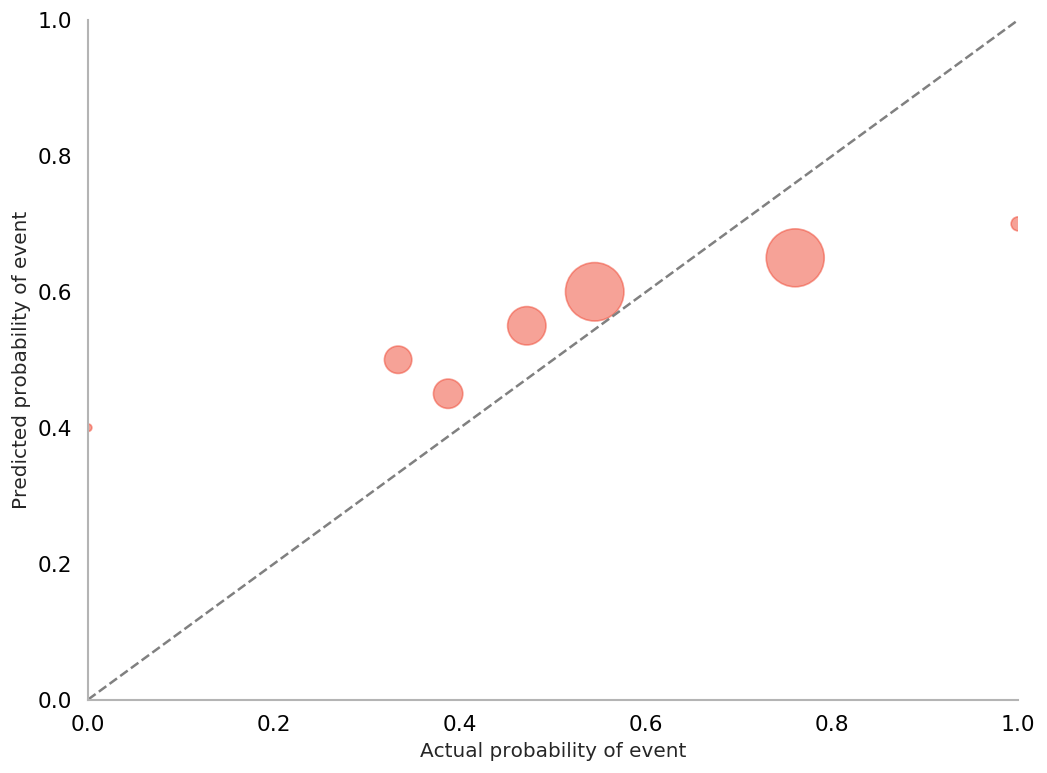

In [61]:
for_plotting = utils.plot_probability(target_idx, predictions_df_valid)
for_plotting.head()

In [62]:
abs(for_plotting['predicted_prob'] - for_plotting['actual_prob']).mean()

0.16764098723192805

In [63]:
abs_error = abs(for_plotting['predicted_prob'] - for_plotting['actual_prob'])
proportions = for_plotting['n_games']/sum(for_plotting['n_games'])
sum(abs_error*proportions)

0.09244505494505496

## Plot precision-recall across thresholds

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


decision_threshold  precision  recall
0                0.10   0.582418     1.0
1                0.11   0.582418     1.0
2                0.12   0.582418     1.0
3                0.13   0.582418     1.0
4                0.14   0.582418     1.0

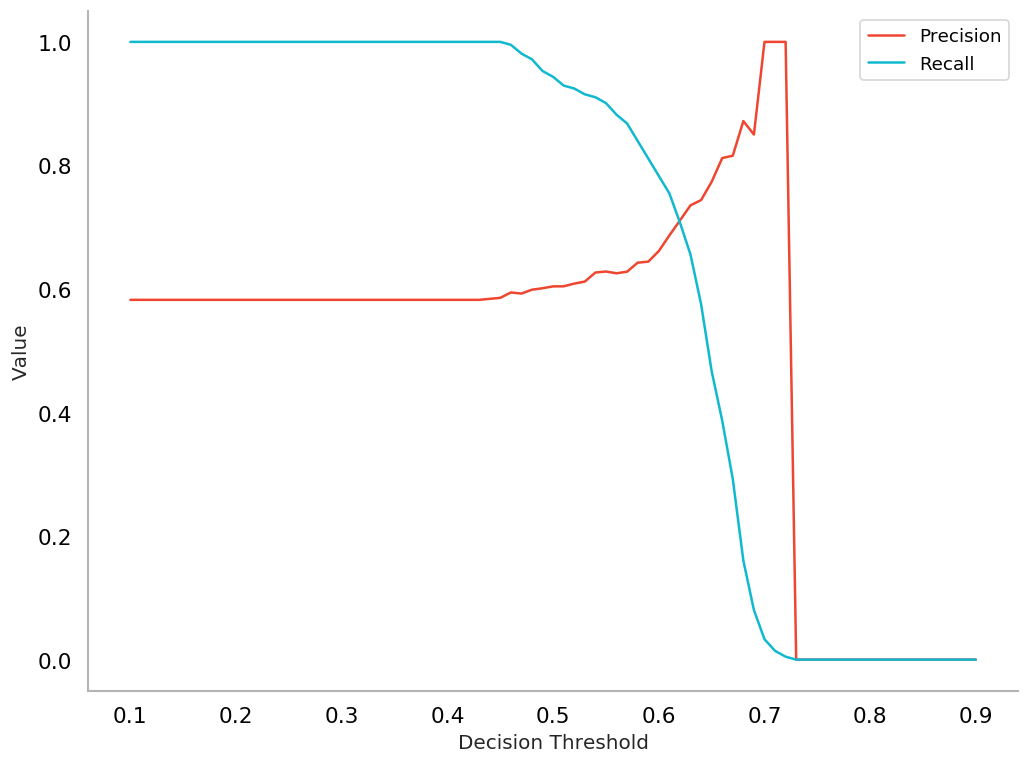

In [64]:
# Plot
y_true = predictions_df_valid['result']
y_pred_proba = predictions_df_valid['pred_proba']
for_plotting = utils.plot_precision_recall(y_true, y_pred_proba)
for_plotting.head()

## Plot ROC curve

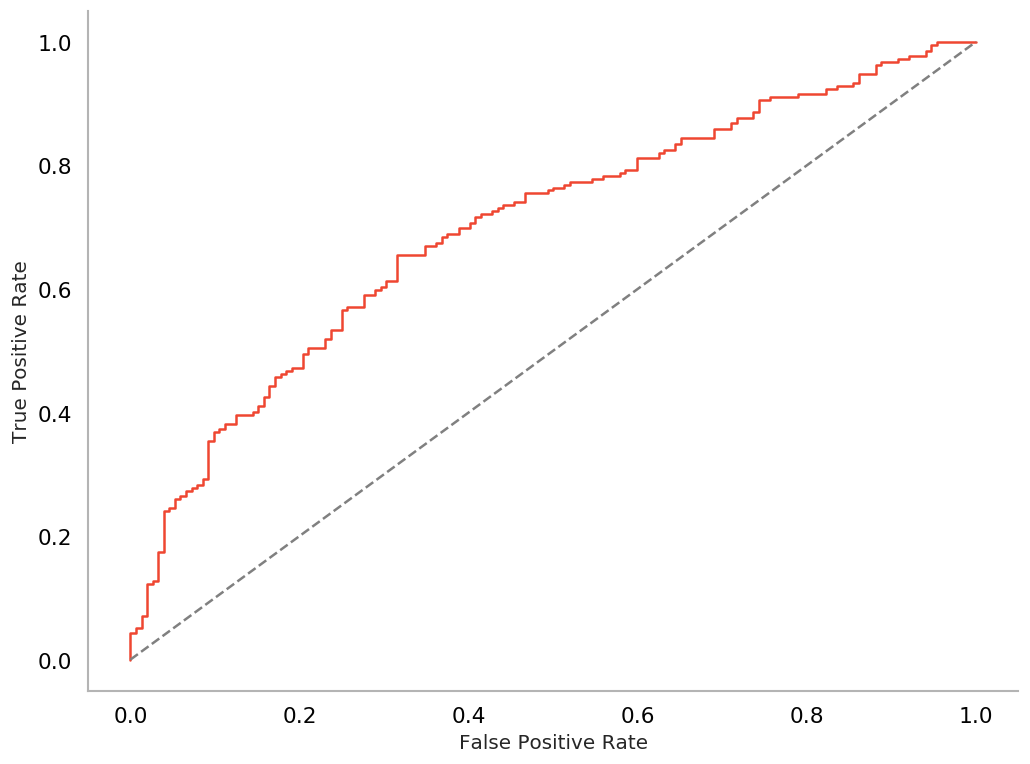

In [65]:
# Plot
y_true = predictions_df_valid['result']
y_pred_proba = predictions_df_valid['pred_proba']
utils.plot_roc_curve(y_true, y_pred_proba)

## SHAP

In [66]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [67]:
# Get target estimator
target_estimator = experiments[target_idx]['estimator']
target_X_valid = experiments[target_idx]['X_valid']

In [68]:
%%time
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)

explainer = shap.TreeExplainer(target_estimator)
shap_values = explainer.shap_values(target_X_valid)

Wall time: 127 ms


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [69]:
explainer.expected_value[1]

0.6131070496083552

### Local explainability

#### Model got right

In [70]:
# Get results df 
results_correct = predictions_df_valid[(predictions_df_valid['result']==predictions_df_valid['pred_default_threshold']) & (abs(predictions_df_valid['pred_proba']-0.5)>=0.1)]
sample = results_correct.sample(1)
sample

original_index  pred_proba  pred_default_threshold  pred_best_threshold  \
117             983    0.666893                     1.0                    1   

     actual  season  month year_month_day             datetime  \
117     1.0    2018  march     2019-03-08  2019-03-08 20:00:00   

           home_team           away_team  home_pts  away_pts  \
117  Houston Rockets  Philadelphia 76ers       107        91   

                                          url_boxscore  result  \
117  https://www.basketball-reference.com//boxscore...     1.0   

     home_kde_lag20_prob  game_number_1_home  win_cumsum_1_home  \
117             0.244369            2.223295           2.564467   

     win_percentage_cumsum_1_home  game_number_1_away  win_cumsum_1_away  \
117                       0.68661            2.296515           2.763392   

     win_percentage_cumsum_1_away  game_number_1_home_home  \
117                      0.845097                 2.139011   

     win_cumsum_1_home_home  win_percentage_cumsum_1_home_home  \
117                2.397933                           0.572602   

     game_number_1_away_away  win_cumsum_1_away_away  \
117                  2.36132                2.854379   

     win_percentage_cumsum_1_away_away  agg_scored_4_lags_home  \
117                           0.864435                0.620622   

     agg_allowed_4_lags_home  agg_pts_differential_4_lags_home  \
117                -0.365531                          0.856173   

     agg_total_pts_4_lags_home  agg_win_rate_4_lags_home  \
117                   0.178019                  1.816144   

     agg_time_delta_cumsum_4_lags_home  agg_timezone_diff_cumsum_4_lags_home  \
117                          -0.251824                              0.263677   

     agg_scored_4_lags_away  agg_allowed_4_lags_away  \
117                0.132776                -0.144254   

     agg_pts_differential_4_lags_away  agg_total_pts_4_lags_away  \
117                           0.23698                  -0.000089   

     agg_win_rate_4_lags_away  agg_time_delta_cumsum_4_lags_away  \
117                       0.0                           0.407119   

     agg_timezone_diff_cumsum_4_lags_away  agg_scored_4_lags_home_home  \
117                             -0.143791                     0.768751   

     agg_allowed_4_lags_home_home  agg_pts_differential_4_lags_home_home  \
117                      0.540444                                0.26231   

     agg_total_pts_4_lags_home_home  agg_win_rate_4_lags_home_home  \
117                        0.821881                        0.51531   

     agg_scored_4_lags_away_away  agg_allowed_4_lags_away_away  \
117                     0.577746                     -0.519202   

     agg_pts_differential_4_lags_away_away  agg_total_pts_4_lags_away_away  \
117                               0.982919                        0.043443   

     agg_win_rate_4_lags_away_away  agg_time_delta_cumsum_4_lags_away_away  \
117                       1.378264                                3.007582   

     agg_timezone_diff_cumsum_4_lags_away_away  bin  interval  
117                                  -0.558519   13      0.65

In [71]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
target_result_index = sample.head(1).index
target_real_index = sample.head(1).original_index
shap.force_plot(explainer.expected_value[1], shap_values[1][target_result_index], target_X_valid.loc[target_real_index,:])

### Global explainability

In [72]:
fi = pd.DataFrame({'fi': estimator.feature_importances_})
fi['features'] = X_train.columns.tolist()
fi.sort_values('fi', ascending=False).head()

fi                          features
0  0.258813      win_percentage_cumsum_1_home
1  0.211810               home_kde_lag20_prob
2  0.160744  agg_pts_differential_4_lags_home
3  0.082109                 win_cumsum_1_home
4  0.078178            agg_scored_4_lags_home

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


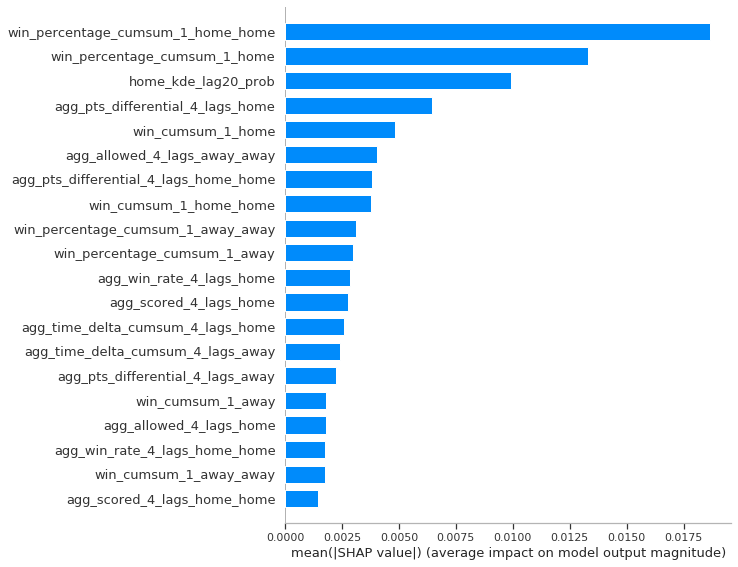

In [73]:
# summarize the effects of all the features
shap.summary_plot(shap_values[1], target_X_valid, plot_type="bar")

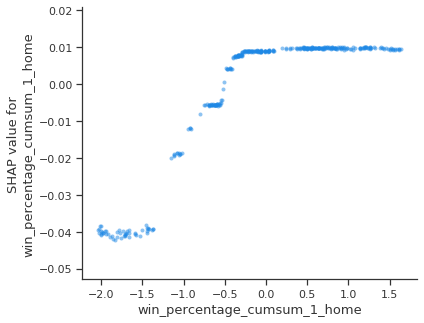

In [74]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("win_percentage_cumsum_1_home", shap_values[1], target_X_valid, interaction_index=None, alpha=0.5)

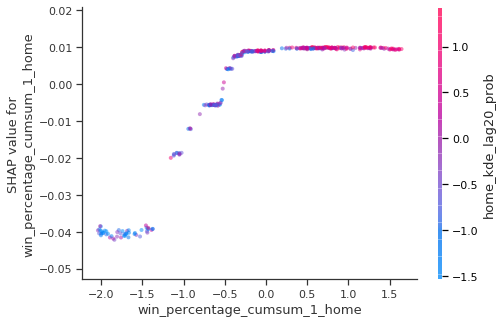

In [75]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("win_percentage_cumsum_1_home", shap_values[1], target_X_valid, interaction_index='home_kde_lag20_prob', alpha=0.5)

# LGBM

In [76]:
from lightgbm import LGBMClassifier

## Set hyperparams

In [77]:
from itertools import product

# Select hyperparams
n_estimators = [100, 500, 1000]
min_child_samples = [20, 100, 150]
feature_set = ['feature_set_01', 'feature_set_02', 'feature_set_03', 'feature_set_04', 'feature_set_05', 'feature_set_06']

# Combinations of hyperparams
params_df = pd.DataFrame(product(n_estimators, min_child_samples, feature_set))
params_df.columns = ['n_estimators', 'min_child_samples', 'feature_set']
params_df

n_estimators  min_child_samples     feature_set
0            100                 20  feature_set_01
1            100                 20  feature_set_02
2            100                 20  feature_set_03
3            100                 20  feature_set_04
4            100                 20  feature_set_05
5            100                 20  feature_set_06
6            100                100  feature_set_01
7            100                100  feature_set_02
8            100                100  feature_set_03
9            100                100  feature_set_04
10           100                100  feature_set_05
11           100                100  feature_set_06
12           100                150  feature_set_01
13           100                150  feature_set_02
14           100                150  feature_set_03
15           100                150  feature_set_04
16           100                150  feature_set_05
17           100                150  feature_set_06
18           500                 20  feature_set_01
19           500                 20  feature_set_02
20           500                 20  feature_set_03
21           500                 20  feature_set_04
22           500                 20  feature_set_05
23           500                 20  feature_set_06
24           500                100  feature_set_01
25           500                100  feature_set_02
26           500                100  feature_set_03
27           500                100  feature_set_04
28           500                100  feature_set_05
29           500                100  feature_set_06
30           500                150  feature_set_01
31           500                150  feature_set_02
32           500                150  feature_set_03
33           500                150  feature_set_04
34           500                150  feature_set_05
35           500                150  feature_set_06
36          1000                 20  feature_set_01
37          1000                 20  feature_set_02
38          1000                 20  feature_set_03
39          1000                 20  feature_set_04
40          1000                 20  feature_set_05
41          1000                 20  feature_set_06
42          1000                100  feature_set_01
43          1000                100  feature_set_02
44          1000                100  feature_set_03
45          1000                100  feature_set_04
46          1000                100  feature_set_05
47          1000                100  feature_set_06
48          1000                150  feature_set_01
49          1000                150  feature_set_02
50          1000                150  feature_set_03
51          1000                150  feature_set_04
52          1000                150  feature_set_05
53          1000                150  feature_set_06

## Modeling

In [78]:
random_state_i = 0

In [79]:
# Train and score over hyperparameter combinations
experiments = {}

import progressbar
bar = progressbar.ProgressBar(maxval=len(params_df))
bar.start()

for i in range(len(params_df)):
    
    # Start recording time
    t0 = time.time()
    
    # Set params
    n_estimators_i = params_df.loc[i,'n_estimators']
    min_child_samples_i = params_df.loc[i,'min_child_samples']
    feature_set_i = params_df.loc[i,'feature_set']
    features_i = feature_selector(feature_set_i)
        
    # Set cutoff dates
    cutoff_date_train = '2018-11-01'
    cutoff_date_test = '2019-01-01'
    cutoff_date_valid = '2019-02-15'

    # Make index list for easy searching later
    index_list = [
        'index', 'season', 'month', 'year_month_day', 'datetime', 'home_team', 'away_team', 'home_pts', 'away_pts', 'url_boxscore', 'result'
    ]

    # Get train, test, validation sets
    train, test, valid = utils.time_splitter(df_raw, cutoff_date_train, cutoff_date_test, cutoff_date_valid)
    
    # Transform df
    train_transformed, train_scaler = utils.feature_transformer(train, features_i, index_list)
    test_transformed, train_scaler = utils.feature_transformer(test, features_i, index_list, train_scaler)
    
    # Get scaler fitted on train and test
    _, train_test_scaler = utils.feature_transformer(train.append(test), features_i, index_list)
    
    # Transform valid using train_test_scaler
    valid_transformed, train_scaler = utils.feature_transformer(valid, features_i, index_list, train_test_scaler)
    
    # Split X's and y's
    X_train, y_train = utils.X_y_splitter(train_transformed, all_features, 'result')
    X_test, y_test = utils.X_y_splitter(test_transformed, all_features, 'result')
    X_valid, y_valid = utils.X_y_splitter(valid_transformed, all_features, 'result')
    
    # Train model
    estimator = LGBMClassifier(n_estimators=n_estimators_i, min_child_samples=min_child_samples_i, random_state=random_state_i)
    estimator.fit(X_train, y_train)
    
    # Score: train
    predictions_df_train, threshold_finder_train = utils.scorer(X_train, y_train, estimator, expected_event_rate=0.6)

    # Score: test
    predictions_df_test, threshold_finder_test = utils.scorer(X_test, y_test, estimator, expected_event_rate=0.6)
    
    # Score: valid
    predictions_df_valid, threshold_finder_valid = utils.scorer(X_valid, y_valid, estimator, expected_event_rate=0.6)
    predictions_df_valid = predictions_df_valid.join(X_valid.reset_index().set_index('index'))
    
    # Compile results 
    results = {
        'train precision': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'train recall': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'train f1': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'train roc': roc_auc_score(predictions_df_train['actual'], predictions_df_train['pred_best_threshold']),
        'test precision': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'test recall': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'test f1': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'test roc': roc_auc_score(predictions_df_test['actual'], predictions_df_test['pred_best_threshold']),
        'valid precision': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'valid recall': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'valid f1': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'valid roc': roc_auc_score(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'])
    }
    
    # Compile experiment params
    params = {
        'n_estimators': n_estimators_i,
        'min_child_samples': min_child_samples_i,
        'feature_set': feature_set_i,
        'train size': len(X_train),
        'test size': len(X_test),
        'valid size': len(X_valid),
        'runtime': time.time() - t0
    }
    
    # Compile all
    experiments[i] = {
        'params': params,
        'results': results,
        'estimator': estimator,
        'predictions_df_valid': predictions_df_valid,
        'X_valid': X_valid
    }
    
    bar.update(i)

 98% (53 of 54) |####################### | Elapsed Time: 0:00:20 ETA:   0:00:00

In [80]:
# Compile experiment results
experiments_df = pd.DataFrame()
for i in experiments.keys():
    experiments_df = experiments_df.append(pd.DataFrame({**experiments[i]['params'], **experiments[i]['results']}, index=[i]))
experiments_df.sort_values('valid precision', ascending=False).head()

n_estimators  min_child_samples     feature_set  train size  test size  \
12           100                150  feature_set_01         383        318   
15           100                150  feature_set_04         383        318   
14           100                150  feature_set_03         383        318   
17           100                150  feature_set_06         383        318   
16           100                150  feature_set_05         383        318   

    valid size   runtime  train precision  train recall  train f1  train roc  \
12         364  0.280250         0.775330      0.748936  0.761905   0.702171   
15         364  0.223403         0.770213      0.770213  0.770213   0.702674   
14         364  0.237365         0.770213      0.770213  0.770213   0.702674   
17         364  0.273108         0.770213      0.770213  0.770213   0.702674   
16         364  0.224400         0.770213      0.770213  0.770213   0.702674   

    test precision  test recall   test f1  test roc  valid precision  \
12        0.726316     0.758242  0.741935  0.687944         0.683486   
15        0.724868     0.752747  0.738544  0.685197         0.671296   
14        0.724868     0.752747  0.738544  0.685197         0.671296   
17        0.724868     0.752747  0.738544  0.685197         0.669725   
16        0.724868     0.752747  0.738544  0.685197         0.669725   

    valid recall  valid f1  valid roc  
12      0.702830  0.693023   0.624441  
15      0.683962  0.677570   0.608429  
14      0.683962  0.677570   0.608429  
17      0.688679  0.679070   0.607498  
16      0.688679  0.679070   0.607498

## Plot predicted vs actual

In [81]:
# Get results df
target_idx =  15
predictions_df_valid = experiments[target_idx]['predictions_df_valid'].copy()

# Make new index for shap
predictions_df_valid.reset_index(inplace=True)
predictions_df_valid.rename(columns={'index': 'original_index'}, inplace=True)
predictions_df_valid.head()

original_index  pred_proba  pred_default_threshold  pred_best_threshold  \
0             866    0.749924                     1.0                    1   
1             867    0.619385                     1.0                    0   
2             868    0.787565                     1.0                    1   
3             869    0.494636                     0.0                    0   
4             870    0.698458                     1.0                    1   

   actual  season     month year_month_day             datetime  \
0     1.0    2018  february     2019-02-21  2019-02-21 22:30:00   
1     0.0    2018  february     2019-02-21  2019-02-21 19:30:00   
2     1.0    2018  february     2019-02-21  2019-02-21 22:30:00   
3     1.0    2018  february     2019-02-21  2019-02-21 19:00:00   
4     1.0    2018  february     2019-02-21  2019-02-21 20:00:00   

               home_team               away_team  home_pts  away_pts  \
0     Los Angeles Lakers         Houston Rockets       111       106   
1          Brooklyn Nets  Portland Trail Blazers        99       113   
2  Golden State Warriors        Sacramento Kings       125       123   
3    Cleveland Cavaliers            Phoenix Suns       111        98   
4        Milwaukee Bucks          Boston Celtics        98        97   

                                        url_boxscore  result  \
0  https://www.basketball-reference.com//boxscore...     1.0   
1  https://www.basketball-reference.com//boxscore...     0.0   
2  https://www.basketball-reference.com//boxscore...     1.0   
3  https://www.basketball-reference.com//boxscore...     1.0   
4  https://www.basketball-reference.com//boxscore...     1.0   

   home_projected_winloss  away_projected_winloss  home_kde_lag20_prob  \
0                0.663873                1.467776            -1.141263   
1               -0.956958                0.049465            -0.792712   
2                2.039124               -1.515567             1.412871   
3               -1.104306               -1.222124             0.150803   
4                0.614757                1.712312             0.642203   

   game_number_1_home  win_cumsum_1_home  win_percentage_cumsum_1_home  \
0            1.707323           1.287038                     -0.070497   
1            1.854744           1.519298                      0.040022   
2            1.707323           2.796727                      1.391019   
3            1.781034          -0.571041                     -1.892546   
4            1.707323           3.028987                      1.615867   

   game_number_1_away  win_cumsum_1_away  win_percentage_cumsum_1_away  \
0            1.706932           1.847217                      0.512971   
1            1.706932           1.961739                      0.625410   
2            1.706932           1.503651                      0.175656   
3            1.854328          -0.672265                     -2.002601   
4            1.780630           2.305304                      0.890997   

   game_number_1_home_home  win_cumsum_1_home_home  \
0                 1.331278                1.110028   
1                 1.771860                1.461275   
2                 1.698429                2.866263   
3                 1.845290               -0.529125   
4                 1.624999                2.866263   

   win_percentage_cumsum_1_home_home  game_number_1_away_away  \
0                           0.024133                 1.773767   
1                           0.017625                 1.700322   
2                           1.426289                 1.773767   
3                          -1.886118                 1.920655   
4                           1.510237                 1.773767   

   win_cumsum_1_away_away  win_percentage_cumsum_1_away_away  scored_1_home  \
0                1.930540                           0.534173          113.0   
1                1.930540                           0.600060          148.0   
2                1.584100

N/A% (0 of 12) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

season  predicted_prob  actual_prob  n_games
0    2018            0.30     0.500000       20
1    2018            0.35     0.111111       90
2    2018            0.40     0.529412      170
3    2018            0.45     0.384615      260
4    2018            0.50     0.441176      340

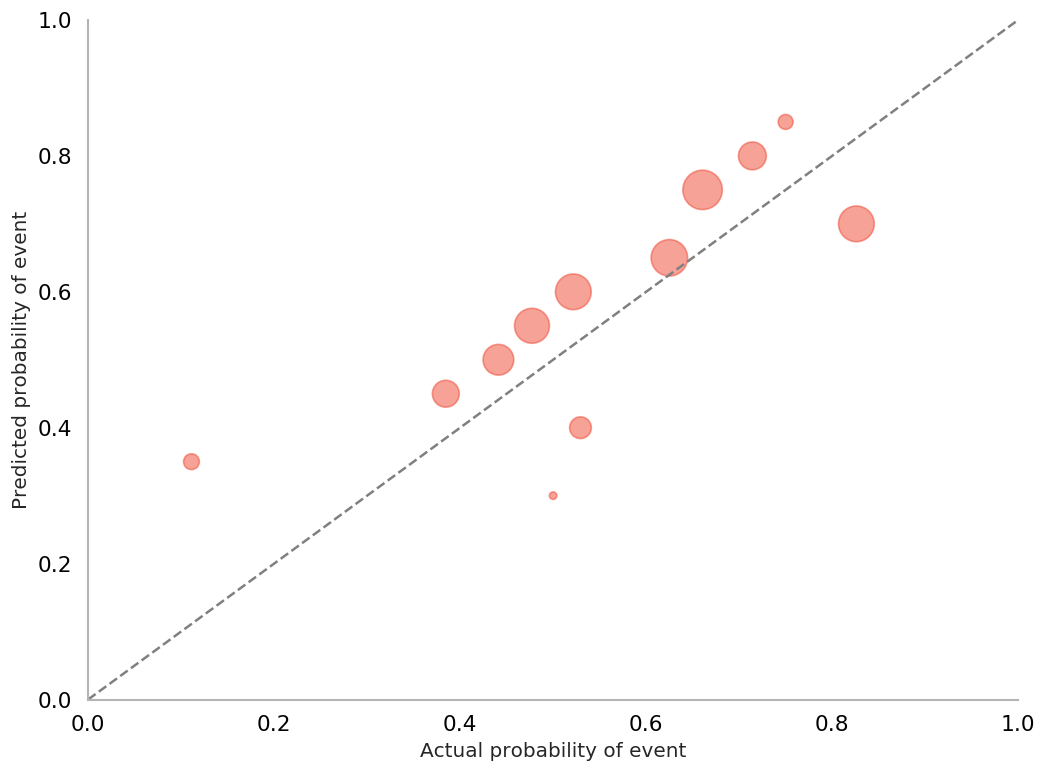

In [82]:
for_plotting = utils.plot_probability(target_idx, predictions_df_valid)
for_plotting.head()

In [83]:
abs(for_plotting['predicted_prob'] - for_plotting['actual_prob']).mean()

0.10579865810044842

In [84]:
abs_error = abs(for_plotting['predicted_prob'] - for_plotting['actual_prob'])
proportions = for_plotting['n_games']/sum(for_plotting['n_games'])
sum(abs_error*proportions)

0.08365384615384618

## Plot precision-recall across thresholds

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


decision_threshold  precision  recall
0                0.10   0.582418     1.0
1                0.11   0.582418     1.0
2                0.12   0.582418     1.0
3                0.13   0.582418     1.0
4                0.14   0.582418     1.0

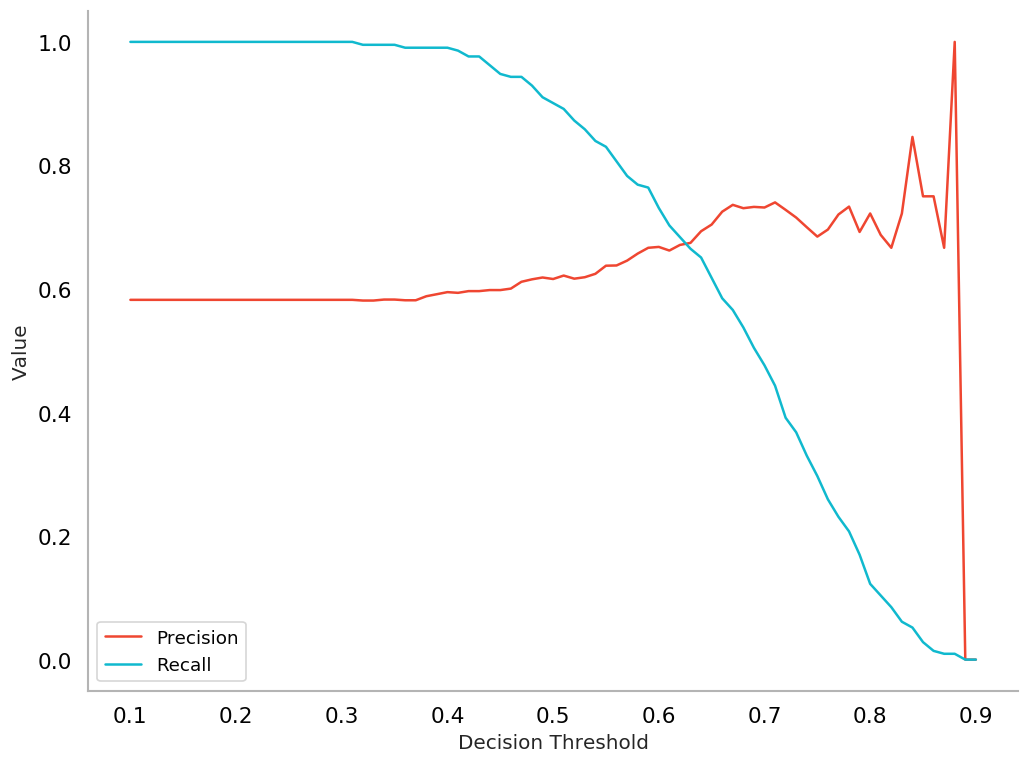

In [85]:
# Plot
y_true = predictions_df_valid['result']
y_pred_proba = predictions_df_valid['pred_proba']
for_plotting = utils.plot_precision_recall(y_true, y_pred_proba)
for_plotting.head()

## Plot ROC curve

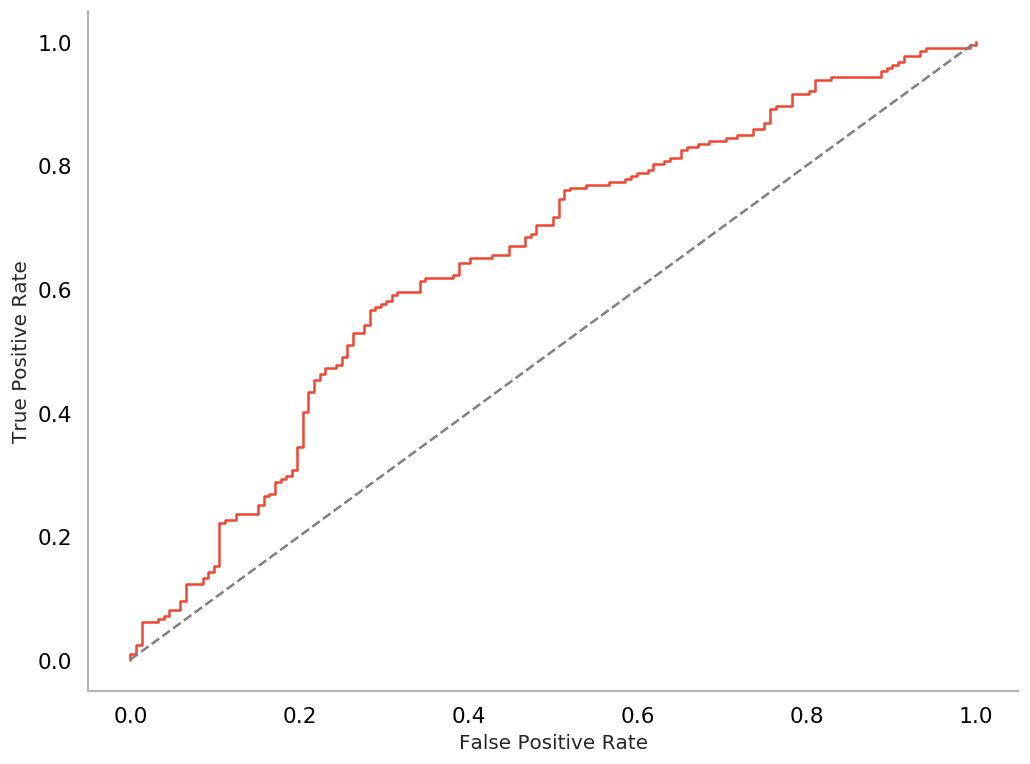

In [86]:
# Plot
y_true = predictions_df_valid['result']
y_pred_proba = predictions_df_valid['pred_proba']
utils.plot_roc_curve(y_true, y_pred_proba)

## SHAP

In [87]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [88]:
# Get target estimator
target_estimator = experiments[target_idx]['estimator']
target_X_valid = experiments[target_idx]['X_valid']

In [89]:
%%time
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)

explainer = shap.TreeExplainer(target_estimator)
shap_values = explainer.shap_values(target_X_valid)

Wall time: 129 ms


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [90]:
explainer.expected_value[1]

0.5003223270163448

### Local explainability

#### Model got right

In [91]:
# Get results df 
results_correct = predictions_df_valid[(predictions_df_valid['result']==predictions_df_valid['pred_default_threshold']) & (abs(predictions_df_valid['pred_proba']-0.5)>=0.1)]
sample = results_correct.sample(1)
sample

original_index  pred_proba  pred_default_threshold  pred_best_threshold  \
31             897    0.857436                     1.0                    1   

    actual  season     month year_month_day             datetime  \
31     1.0    2018  february     2019-02-25  2019-02-25 20:00:00   

          home_team      away_team  home_pts  away_pts  \
31  Houston Rockets  Atlanta Hawks       119       111   

                                         url_boxscore  result  \
31  https://www.basketball-reference.com//boxscore...     1.0   

    home_projected_winloss  away_projected_winloss  home_kde_lag20_prob  \
31                1.449731               -1.760103             1.022895   

    game_number_1_home  win_cumsum_1_home  win_percentage_cumsum_1_home  \
31            1.854744           1.983817                      0.474475   

    game_number_1_away  win_cumsum_1_away  win_percentage_cumsum_1_away  \
31            1.928025           0.358432                     -1.061167   

    game_number_1_home_home  win_cumsum_1_home_home  \
31                 1.698429                1.929604   

    win_percentage_cumsum_1_home_home  game_number_1_away_away  \
31                           0.525376                  1.47999   

    win_cumsum_1_away_away  win_percentage_cumsum_1_away_away  scored_1_home  \
31                0.198342                          -0.991047          118.0   

    allowed_1_home  result_1_home  pts_differential_1_home  time_delta_1_home  \
31           112.0            1.0                      6.0           1.916667   

    time_delta_cumsum_1_home  timezone_diff_1_home  \
31                      14.0                   2.0   

    timezone_diff_cumsum_1_home  scored_2_home  allowed_2_home  result_2_home  \
31                          4.0          106.0           111.0            0.0   

    pts_differential_2_home  game_number_2_home  win_cumsum_2_home  \
31                     -5.0                58.0               33.0   

    win_percentage_cumsum_2_home  time_delta_2_home  time_delta_cumsum_2_home  \
31                      0.568966           8.104167                 12.083333   

    timezone_diff_2_home  timezone_diff_cumsum_2_home  scored_3_home  \
31                   2.0                          2.0          111.0   

    allowed_3_home  result_3_home  pts_differential_3_home  \
31           121.0            0.0                    -10.0   

    game_number_3_home  win_cumsum_3_home  win_percentage_cumsum_3_home  \
31                57.0               33.0                      0.578947   

    time_delta_3_home  time_delta_cumsum_3_home  timezone_diff_3_home  \
31                2.0                  3.979167                   0.0   

    timezone_diff_cumsum_3_home  scored_4_home  allowed_4_home  result_4_home  \
31                          0.0          120.0           104.0            1.0   

    pts_differential_4_home  game_number_4_home  win_cumsum_4_home  \
31                     16.0                56.0               33.0   

    win_percentage_cumsum_4_home  time_delta_4_home  time_delta_cumsum_4_home  \
31                      0.589286           1.979167                  1.979167   

    timezone_diff_4_home  timezone_diff_cumsum_4_home  scored_1_away  \
31                   0.0                          0.0          120.0   

    allowed_1_away  result_1_away  pts_differential_1_away  time_delta_1_away  \
31           112.0            1.0                      8.0           0.979167   

    time_delta_cumsum_1_away  timezone_diff_1_away  \
31                 12.979167                   0.0   

    timezone_diff_cumsum_1_away  scored_2_away  allowed_2_away  result_2_away  \
31                          0.0          122.0           125.0            0.0   

    pts_differential_2_away  game_number_2_away  win_cumsum_2_away  \
31                     -3.0                59.0               19.0   

    win_percentage_cumsum_2_away  time_delta_2_away  time_delta_cumsum_2_away  \
31                      0.

In [92]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
target_result_index = sample.head(1).index
target_real_index = sample.head(1).original_index
shap.force_plot(explainer.expected_value[1], shap_values[1][target_result_index], target_X_valid.loc[target_real_index,:], link="logit")

### Global explainability

In [93]:
estimator

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=150, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [94]:
fi = pd.DataFrame({'fi': estimator.feature_importances_})
fi['features'] = X_train.columns.tolist()
fi.sort_values('fi', ascending=False).head()

fi                           features
14   44  win_percentage_cumsum_1_away_away
100  43       pts_differential_1_home_home
2    32                home_kde_lag20_prob
167  28       agg_allowed_4_lags_away_away
34   25                      scored_3_home

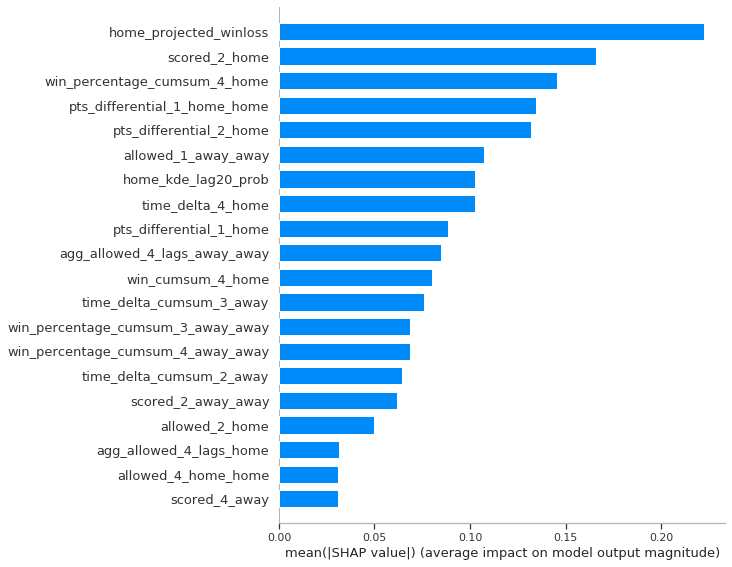

In [95]:
# summarize the effects of all the features
shap.summary_plot(shap_values[1], target_X_valid, plot_type="bar")

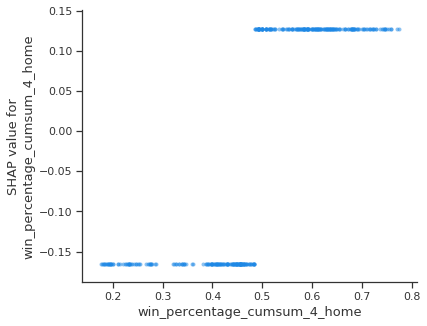

In [96]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("win_percentage_cumsum_4_home", shap_values[1], target_X_valid, interaction_index=None, alpha=0.5)

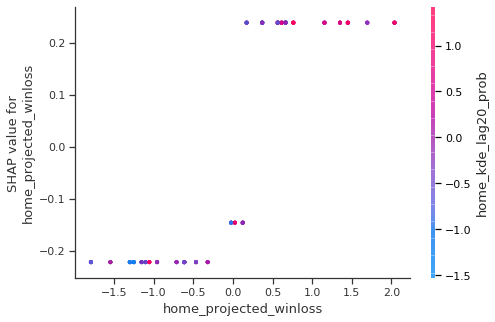

In [97]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("home_projected_winloss", shap_values[1], target_X_valid, interaction_index='home_kde_lag20_prob', alpha=0.5)